# To get the total a customer has spent, we need to do the follow:
Order Items (order_id) must be joined to the Orders (order_id) to get the (customer_id). The (customer_id) of Orders must be joined to Customers.
The sum of price on all the same order_id's (in Order Items CSV), and once joined to orders and customers, we then have the customer_unique_id.
Fit the customers into clusters, then you will have segmented based on RFM values.


In [15]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [16]:
# Load and merge CSV files
items = pd.read_csv("data/olist_order_items_dataset.csv")
orders = pd.read_csv("data/olist_orders_dataset.csv")
customers = pd.read_csv("data/olist_customers_dataset.csv")
data = pd.merge(items, orders, on="order_id")
data = pd.merge(data, customers, on="customer_id")

In [17]:
# Preprocess data
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)
data = data[data["order_status"] == "delivered"]

In [18]:
# Select RFM features
data["order_purchase_timestamp"] = pd.to_datetime(data["order_purchase_timestamp"])
max_date = data["order_purchase_timestamp"].max() # gets the latest purchase
data["recency"] = (max_date - data["order_purchase_timestamp"]).dt.days # days since last purchase 
rfm = data.groupby("customer_unique_id").agg({"order_id": "nunique", "price": "sum", "recency": "min"})
rfm.columns = ["frequency", "monetary", "recency"]

# NOTE: Check that standardising is needed or not.
# Standardise RFM features
# scaler = StandardScaler()
# rfm_scaled = scaler.fit_transform(rfm)
rfm_scaled = rfm

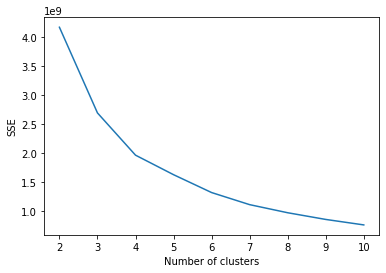

In [19]:
# Determine optimal number of clusters (using elbow method)
sse = [] # sum of squared errors 
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)
plt.plot(range(2, 11), sse)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

In [20]:
# Apply K-means clustering using k=4 (based on the elbow method chart above)
kmeans = KMeans(n_clusters=4)
kmeans.fit(rfm_scaled)
rfm["cluster"] = kmeans.labels_

# Analyse cluster characteristics
rfm.groupby("cluster").describe()

frequency                                               monetary  \
            count      mean       std  min  25%  50%  75%   max    count   
cluster                                                                    
0         36709.0  1.024653  0.165767  1.0  1.0  1.0  1.0   6.0  36709.0   
1         49993.0  1.029144  0.179042  1.0  1.0  1.0  1.0   5.0  49993.0   
2           745.0  1.088591  0.377728  1.0  1.0  1.0  1.0   5.0    745.0   
3          5889.0  1.117337  0.472749  1.0  1.0  1.0  1.0  15.0   5889.0   

                      ...                    recency                          \
                mean  ...      75%      max    count        mean         std   
cluster               ...                                                      
0          99.853373  ...   134.99    419.9  36709.0  387.496908   95.781667   
1          99.398961  ...   138.99    364.3  49993.0  127.092173   72.522621   
2        1761.009356  ...  1977.00  13440.0    745.0  242.153020  160.435750   
3         555.557444  ...   666.00   1155.0   5889.0  229.735269  141.334828   

                                            
           min    25%    50%    75%    max  
cluster                                     
0        257.0  300.0  375.0  461.0  713.0  
1          0.0   64.0  128.0  189.0  257.0  
2          3.0  102.0  229.0  360.0  690.0  
3          0.0  118.0  214.0  317.0  693.0  

[4 rows x 24 columns]

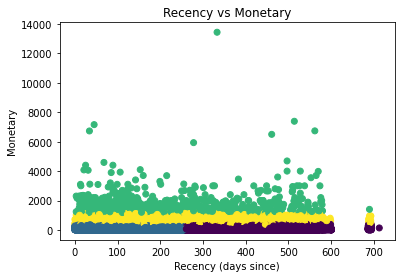

In [21]:
plt.scatter(rfm_scaled["recency"], rfm["monetary"], c=rfm["cluster"])
plt.xlabel("Recency (days since)")
plt.ylabel("Monetary")
plt.title("Recency vs Monetary")
plt.show()

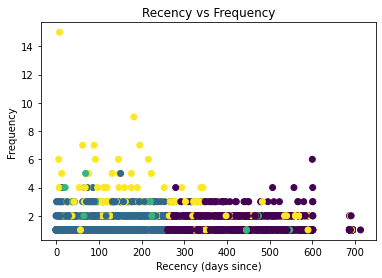

In [22]:
plt.scatter(rfm_scaled["recency"], rfm["frequency"], c=rfm["cluster"])
plt.xlabel("Recency (days since)")
plt.ylabel("Frequency")
plt.title("Recency vs Frequency")
plt.show()

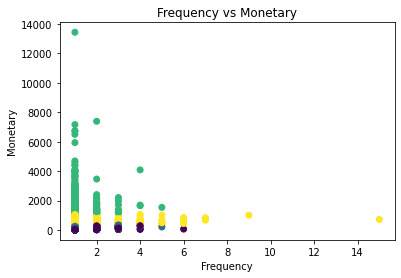

In [23]:
plt.scatter(rfm_scaled["frequency"], rfm["monetary"], c=rfm["cluster"])
plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.title("Frequency vs Monetary")
plt.show()

# Summary of RFM segmentation
* A cluster size of 4 seems most suitable.
* Cluster 0 = worse customer, provides little to the business.
* Cluster 4 = best customer, provides good value to the business.